# Megatron-DeepSpeed 学习
### 目标
这里notebook的目的主要是跑通Megatron-deepspeed 的demo模型脚本并SFT小模型测试。 因此， 这里以BERT (encoder)和GPT (decoder) pretraining的demo进行学习.
学习目标：
- 熟悉Megatron从数据集，模型到训练一条流程，以及参数的设置
- 分布式训练的参数在不同资源机器环境下调优
- 指标： MFU (Model FLOPS Utilizatoin), HFU (Hardward FLOPS Utilization)


### 数据
**数据集1：(demo 只用了这个数据集 pretrain， 不是SFT)**
- modelscope下载的 mixture-of-though  science数据集
- 数据格式如下：
    - {'messages':[{'content': 'xxx', 'role': 'user'}， {'content': 'xxx', 'role': 'assistant'}  ], 'num_tokens': <token数量>, 'source': <数据来源>}
    - 每一行是一个json， 每条json记录里message是一个列表，记录用户问题和助手答案(CoT). 同时也标注message的来源和token数


**数据集2：**
- 从modelscope 下载医药健康相关的数据集 xiaofengalg/qizen-gpt-sample-sft-20k
- 数据格式: {'instuction':'xxx', 'input': 'xxx', 'output': 'xxx'}. 这里的instruction和input输入到模型里时是合并一起的，所以input为空也无关系。 output是文本答案。 
- 注意: 这里数据集的output是开放性回答， 并非选择题， 和数学推理选择数据集不一样。因此 模型评估时不用考虑选项是否正确去打分，而更多是对内容评估

### 模型
GPT2 356M 小模型 + tokenizer

### 单机测试
- 这里用了science数据集的一小部分做训练集
~~~
INFO:megatron.core.timers:(min, max) time across ranks (ms):
    model-and-optimizer-setup ......................: (466.46, 466.46)
    train/valid/test-data-iterators-setup ..........: (3612.98, 3612.98)
~~~


### 线上多GPU训练
待测试

### 推理
待测试

# 0. 环境安装

### megatron-lm 安装
**最简单的安装方法**
~~~shell
git clone https://github.com/NVIDIA/Megatron-LM.git 
cd Megatron-LM
pip install --no-build-isolation megatron-core[dev]
pip install six regex
~~~

如果按照过程中遇到dependencies的安装问题， 大概率是cuda toolkit没安装好， 或者是 CUDA版本和torch以及megatron不兼容。 详细方法参考下面：

### 遇到CUDA (10.1)版本不兼容或者cutlass 头文件没有检测到

~~~shell
# 目前megatron不支持CUDA=10.0, 需要限制CUDA_ARCH架构
export TORCH_CUDA_ARCH_LIST="8.0;8.6;8.9;9.0"

# 下面安装megatron-lm的nv-grouped-gemm模块有可能会报错说找不到cutlass文件， 需要先做以下操作
git clone https://github.com/NVIDIA/cutlass.git 
export CUTLASS_PATH=$PWD/cutlass

# 2. 确认头文件存在
ls $CUTLASS_PATH/include/cutlass/bfloat16.h        # 应该能看到
ls $CUTLASS_PATH/include/cutlass/arch/memory.h 
export CPLUS_INCLUDE_PATH=$CUTLASS_PATH/include:$CPLUS_INCLUDE_PATH
pip install --no-cache-dir nv-grouped-gemm

pip install "setuptools<80.0.0,>=77.0.0" "packaging>=24.2"
pip install --no-build-isolation megatron-core[dev]
pip install six regex

~~~

### transformer_engine 安装问题
~~~shell

export MAX_JOBS=2
# 重新安装cuda-toolkit
conda install -c nvidia cuda-toolkit=12.8

# 如果安装transformer_engine_torch 报错说 nvToolsExt.h没找到
find $CONDA_PREFIX -name nvToolsExt.h
# 会返回以下路径
#/home/wwk/workspace/miniconda3/envs/megatron_env_py12/nsight-compute-2025.1.1/host/target-linux-x64/nvtx/include/nvtx3/nvToolsExt.h
#/home/wwk/workspace/miniconda3/envs/megatron_env_py12/lib/python3.12/site-packages/nvidia/nvtx/include/nvToolsExt.h
#/home/wwk/workspace/miniconda3/envs/megatron_env_py12/lib/python3.12/site-packages/nvidia/nvtx/include/nvtx3/nvToolsExt.h

#重新指定没检测到的nvToolsExt.h 文件路径
export CPLUS_INCLUDE_PATH=/home/wwk/workspace/miniconda3/envs/megatron_env_py12/lib/python3.12/site-packages/nvidia/nvtx/include:$CPLUS_INCLUDE_PATH
export LIBRARY_PATH=/home/wwk/workspace/miniconda3/envs/megatron_env_py12/lib/python3.12/site-packages/nvidia/nvtx/lib:$LIBRARY_PATH

# 之后重新安装transformer_engine_torch 
pip install --no-cache-dir transformer_engine_torch

#或直接安装megatron
pip install --no-build-isolation megatron-core[dev]

~~~

### Apex 安装

~~~shell
cd ./Megatron-LM
git clone https://github.com/NVIDIA/apex.git
cd apex
pip install --no-build-isolation   --config-settings=--build-option=--cpp_ext   --config-settings=--build-option=--cuda_ext   -v .
cd -
~~~

# 1. 代码和数据集下载

In [ ]:
#python==3.12
# ! pip install pybind11 && conda install cudatoolkit=11.8.0 
!git clone https://github.com/NVIDIA/Megatron-LM.git 

Cloning into 'Megatron-LM'...
remote: Enumerating objects: 79772, done.
remote: Counting objects: 100% (369/369), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 79772 (delta 276), reused 178 (delta 176), pack-reused 79403 (from 2)
Receiving objects: 100% (79772/79772), 42.72 MiB | 1.70 MiB/s, done.
Resolving deltas: 100% (56680/56680), done.


In [1]:
! git clone https://github.com/deepspeedai/Megatron-DeepSpeed.git

Cloning into 'Megatron-DeepSpeed'...
remote: Enumerating objects: 16303, done.
remote: Total 16303 (delta 0), reused 0 (delta 0), pack-reused 16303 (from 1)
Receiving objects: 100% (16303/16303), 8.03 MiB | 2.05 MiB/s, done.
Resolving deltas: 100% (12220/12220), done.


In [1]:
# !cd Megatron-LM && pip install --no-build-isolation .[mlm,dev]

# 2. 数据集准备

In [3]:
# download dataset
! mkdir dataset && mkdir dataset/qizhen-medical-sft-data/ && modelscope download --dataset xiaofengalg/qizen-gpt-sample-sft-20k --local_dir ./dataset/qizhen-medical-sft-data/ 

/home/wwk/workspace/miniconda3/envs/llm_study/lib/python3.13/site-packages/modelscope/utils/plugins.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources

 _   .-')                _ .-') _     ('-.             .-')                              _ (`-.    ('-.
( '.( OO )_             ( (  OO) )  _(  OO)           ( OO ).                           ( (OO  ) _(  OO)
 ,--.   ,--.).-'),-----. \     .'_ (,------.,--.     (_)---\_)   .-----.  .-'),-----.  _.`     \(,------.
 |   `.'   |( OO'  .-.  ',`'--..._) |  .---'|  |.-') /    _ |   '  .--./ ( OO'  .-.  '(__...--'' |  .---'
 |         |/   |  | |  ||  |  \  ' |  |    |  | OO )\  :` `.   |  |('-. /   |  | |  | |  /  | | |  |
 |  |'.'|  |\_) |  |\|  ||  |   ' |(|  '--. |  |`-' | '..`''.) /_) |OO  )\_) |  |\|  | |  |_.' |(|  '--.

In [6]:
!modelscope download --dataset open-r1/Mixture-of-Thoughts --local_dir ./dataset/mixture_of_thoughts

/home/wwk/workspace/miniconda3/envs/llm_study/lib/python3.13/site-packages/modelscope/utils/plugins.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources

 _   .-')                _ .-') _     ('-.             .-')                              _ (`-.    ('-.
( '.( OO )_             ( (  OO) )  _(  OO)           ( OO ).                           ( (OO  ) _(  OO)
 ,--.   ,--.).-'),-----. \     .'_ (,------.,--.     (_)---\_)   .-----.  .-'),-----.  _.`     \(,------.
 |   `.'   |( OO'  .-.  ',`'--..._) |  .---'|  |.-') /    _ |   '  .--./ ( OO'  .-.  '(__...--'' |  .---'
 |         |/   |  | |  ||  |  \  ' |  |    |  | OO )\  :` `.   |  |('-. /   |  | |  | |  /  | | |  |
 |  |'.'|  |\_) |  |\|  ||  |   ' |(|  '--. |  |`-' | '..`''.) /_) |OO  )\_) |  |\|  | |  |_.' |(|  '--.

下面把parquet 格式数据集解压成json格式数据

In [9]:
import pyarrow.parquet as pq
import json

def parquet_to_jsonl(parquet_path, jsonl_path):
    table = pq.read_table(parquet_path)
    df = table.to_pandas()

    with open(jsonl_path, 'w+') as f:
        i = 0
        for _, row in df.iterrows():
            i +=1
            # Assuming your text is in a column named 'text'
            # doc = {"text": row['text']} 
            if i<3:
                print("row: ", type(row))
                print("row keys: ", row.keys())
                print("messages: ", row['messages'])
                print("num_tokens: ", row['num_tokens'])
                print("source: ", row['source'])
            question = row['messages'][0]['content']
            question_role = row['messages'][0]['role']
            answer = row['messages'][1]['content']
            answer_role = row['messages'][1]['role']
            data = {'text': "question:\n" + question + "answer:\n"+answer,"output":answer, "input":question, "instruction":'', 'role':answer_role}
            if i>10000:
                break
            f.write(json.dumps(data) + '\n')
            
parquet_path="dataset/mixture_of_thoughts/science/train-00000-of-00004.parquet"
jsonl_path="dataset/json_data/science/data.json"
parquet_to_jsonl(parquet_path, jsonl_path)

row:  <class 'pandas.core.series.Series'>
row keys:  Index(['messages', 'num_tokens', 'source'], dtype='object')
messages:  [{'content': 'What are examples of food-safe polyelectrolytes that act as bases and develop positive charges along the polymer?A: glucosamine, chitin, chitosan\nB: xylan, mannan, galactan\nC: pectin, alginate, carrageenan\nD: cellulose, lignin, hemi cellulose', 'role': 'user'}
 {'content': '<think>\nOkay, let me try to figure this out. The question is asking about food-safe polyelectrolytes that act as bases and develop positive charges along the polymer. The options are A to D, each listing different polysaccharides or related compounds. \n\nFirst, I need to recall what polyelectrolytes are. They are polymers that have charged groups, right? So, they can be either polycations (positively charged) or polyanions (negatively charged) when dissolved in water. The question specifically mentions bases, which typically accept protons (H+), so maybe these polymers would 

In [7]:
import json

with open("dataset/qizhen-medical-sft-data/qizhen-gpt-sft-20k.json", 'r') as fp:
    data = json.load(fp)
data[0]

{'instruction': '如何使用榅桲果？',
 'input': '',
 'output': '榅桲果可以煎汁内服，也可如膏剂服用。服药时要遵循医嘱，不要自行增加或减少药量。\n\n煎汁内服时，每日常规用量为10～30克。\n\n外用时，取适量榅桲果挤出汁液，滴入尿道中，可治疗尿道灼痛。'}

**数据预处理**

下面把json的明文数据通过process_data.py脚本和GPT2BPETokenizer tokenizer进行多线程文本token化和预处理成bin格式的数据集并保存， 加快模型训练时数据处理


In [15]:
%%writefile Megatron-LM/start_process_data.sh

#!/bin/bash
#my_data="../dataset/json_data/science/train_data.json"
# my_data="../dataset/json_data/science/data.json"
export PYTHONPATH='/home/wwk/workspace/miniconda3/envs/megatron_env_py12/bin/python'
# my_data="../dataset/qizhen-medical-sft-data/qizhen-gpt-sft-20k.json"
my_data="../dataset/json_data/science/data.json"

data_root="../models"
vocab_file=${data_root}/"gpt2-vocab.json"
merge_file=${data_root}/"gpt2-merges.txt"

echo "python version "
python --version
# alias python="/home/wwk/workspace/miniconda3/envs/megatron_env_py12/bin/python"
#echo python tools/preprocess_data.py \
#        --input ${my_data} \
#        --output_prefix my_medical_dataset \
#        --vocab_file ${vocab_file} \
#        --merge_file ${merge_file} \
#        --dataset-impl mmap \
#        --tokenizer-type GPT2BPETokenizer \
#        --workers 8

echo 'python tools/preprocess_data.py \
        --input ${my_data} \
        --output-prefix ../dataset/science_dataset \
        --vocab-file ${vocab_file} \
        --merge-file ${merge_file} \
        --json-keys input output instruction \
        --tokenizer-type GPT2BPETokenizer \
        --workers 8'
cp tools/preprocess_data.py  ./
python preprocess_data.py \
        --input ${my_data} \
        --output-prefix "../dataset/science_dataset" \
        --vocab-file ${vocab_file} \
        --merge-file ${merge_file} \
        --json-keys text \
        --tokenizer-type GPT2BPETokenizer \
        --workers 8

Overwriting Megatron-LM/start_process_data.sh


In [16]:
!cd Megatron-LM && bash start_process_data.sh

python version 
Python 3.13.9
python tools/preprocess_data.py \
        --input ${my_data} \
        --output-prefix ../dataset/science_dataset \
        --vocab-file ${vocab_file} \
        --merge-file ${merge_file} \
        --json-keys input output instruction \
        --tokenizer-type GPT2BPETokenizer \
        --workers 8
/home/wwk/workspace/ai_project/AlgorithmCodingPractice/DistributeTraining/Megatron-LM/megatron/core/distributed/fsdp/src/megatron_fsdp/utils.py:109: UserWarning: Transformer Engine and Apex are not installed. Falling back to local implementations of multi_tensor_applier and multi_tensor_scale
  warnings.warn(
/home/wwk/workspace/ai_project/AlgorithmCodingPractice/DistributeTraining/Megatron-LM/megatron/core/optimizer/__init__.py:24: UserWarning: Transformer Engine and Apex are not installed. Falling back to Torch optimizers.
  warnings.warn(
/home/wwk/workspace/ai_project/AlgorithmCodingPractice/DistributeTraining/Megatron-LM/megatron/core/optimizer/optimizer.p

# 3.下载模型文件和训练

In [ ]:
#download vocab files 
!wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt
!wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt

!wget https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json
!wget https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt 

--2025-12-13 19:45:47--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt
Connecting to 172.22.48.1:7890... connected.
Proxy request sent, awaiting response... 200 OK
Length: 213450 (208K) [text/plain]
Saving to: ‘bert-large-cased-vocab.txt.1’

bert-large-cased-vo 100%[===================>] 208.45K   338KB/s    in 0.6s    

2025-12-13 19:45:49 (338 KB/s) - ‘bert-large-cased-vocab.txt.1’ saved [213450/213450]

--2025-12-13 19:45:49--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt
Connecting to 172.22.48.1:7890... connected.
Proxy request sent, awaiting response... 200 OK
Length: 231508 (226K) [text/plain]
Saving to: ‘bert-large-uncased-vocab.txt.1’

bert-large-uncased- 100%[===================>] 226.08K   305KB/s    in 0.7s    

2025-12-13 19:45:51 (305 KB/s) - ‘bert-large-uncased-vocab.txt.1’ saved [231508/231508]

--2025-12-13 19:45:52--  https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json
Connecting to 1

In [12]:
# !ls
!mkdir models && mv bert-large* gpt2-* models/
!ls models/

mkdir: cannot create directory ‘models’: File exists
bert-large-cased-vocab.txt    bert-large-uncased-vocab.txt    gpt2-merges.txt
bert-large-cased-vocab.txt.1  bert-large-uncased-vocab.txt.1  gpt2-vocab.json


# 4. Megatron训练参数调整
由于单机测试跑起来很慢， 这里设置batch_size=256, log_interval=10, minibatch=1

In [31]:
%%writefile Megatron-LM/run_gpt_345M_sft.sh
#!/bin/bash
# #!/usr/bin/sh
# Runs the "175B" parameter model
#source ~/.bashrc

#conda activate llm_study

export CUDA_DEVICE_MAX_CONNECTIONS=1
export PYTHONPATH='/home/wwk/workspace/miniconda3/envs/megatron_env_py12/bin/python'
export HF_ENDPOINT=https://hf-mirror.com

export NCCL_P2P_DISABLE=1           # 关闭 P2P
export NCCL_IB_DISABLE=1 
#export HF_ENDPOINT=https://mirrors.tuna.tsinghua.edu.cn/hugging-face-hub



# source ~/.bashrc
# echo source ../megatron-env/bin/activate
# source ../megatron-env/bin/activate
# export PYTHONPATH='/mnt/workspace/Megatron/megatron-env/bin/'
# export PYTHONPATH=/mnt/workspace/Megatron/Megatron-LM:$PYTHONPATH

#GPUS_PER_NODE=8
GPUS_PER_NODE=1
# Change for multinode config
MASTER_ADDR=localhost
MASTER_PORT=6000
NUM_NODES=1
NODE_RANK=0
# WORLD_SIZE=$(($GPUS_PER_NODE*$NUM_NODES))
# WORLD_SIZE=128

# CHECKPOINT_PATH=$1 #<Specify path>
# TENSORBOARD_LOGS_PATH=$2 #<Specify path>
# VOCAB_FILE=$3 #<Specify path to file>/gpt2-vocab.json
# MERGE_FILE=$4 #<Specify path to file>/gpt2-merges.txt
# DATA_PATH=$5 #<Specify path and file prefix>_text_document

root='../models'
ckpt_path=$root/'checkpoint'
# ckpt_path=''
tensorboard_log=$root/'tensor_board_logs'
vocab_file='../models/gpt2-vocab.json'
merge_file='../models/gpt2-merges.txt'
data_path='../dataset/science_dataset_text_document'


CHECKPOINT_PATH=$ckpt_path #<Specify path>
TENSORBOARD_LOGS_PATH=$tensorboard_log #<Specify path>
VOCAB_FILE=$vocab_file #<Specify path to file>/gpt2-vocab.json
MERGE_FILE=$merge_file #<Specify path to file>/gpt2-merges.txt
# DATA_PATH=$data_path
DATA_PATH=$data_path

DISTRIBUTED_ARGS=(
    --nproc_per_node $GPUS_PER_NODE 
    --nnodes $NUM_NODES 
    --master_addr $MASTER_ADDR 
    --master_port $MASTER_PORT
)

# GPT_MODEL_ARGS=(
#     --num-layers 96 
#     --hidden-size 12288 
#     --num-attention-heads 96 
#     --seq-length 2048 
#     --max-position-embeddings 2048 
#     --attention-backend auto # Can use (flash/fused/unfused/local)
# )

# GPT_MODEL_ARGS=(
#     --num-layers 24 
#     --hidden-size 10234 
#     --num-attention-heads 1 
#     --seq-length 1024 
#     --max-position-embeddings 1024 
#     --attention-backend auto # Can use (flash/fused/unfused/local)
# )

GPT_MODEL_ARGS=(
    --num-layers 12
    --hidden-size 768
    --num-attention-heads 12
    --seq-length 1024 
    --max-position-embeddings 1024 
    --attention-backend auto # Can use (flash/fused/unfused/local)
)


TRAINING_ARGS=(
    --micro-batch-size 1 
    --global-batch-size 256 
    --train-iters 50 
    --weight-decay 0.1 
    --adam-beta1 0.9 
    --adam-beta2 0.95 
    --init-method-std 0.006 
    --clip-grad 1.0 
    --fp16
    --lr 2.0e-5 
    --lr-decay-style cosine 
    --min-lr 6.0e-6
    --lr-warmup-fraction .001 
    --lr-decay-iters 430000 
)
# TRAINING_ARGS=(
#     --micro-batch-size 1 
#     --global-batch-size 1536 
#     --rampup-batch-size 16 16 5859375 
#     --train-iters 500000 
#     --weight-decay 0.1 
#     --adam-beta1 0.9 
#     --adam-beta2 0.95 
#     --init-method-std 0.006 
#     --clip-grad 1.0 
#     --fp16
#     --lr 6.0e-5 
#     --lr-decay-style cosine 
#     --min-lr 6.0e-6
#     --lr-warmup-fraction .001 
#     --lr-decay-iters 430000 
# )

MODEL_PARALLEL_ARGS=(
	--tensor-model-parallel-size 1
	--pipeline-model-parallel-size 1 
)

DATA_ARGS=(
    --data-path $DATA_PATH 
    --vocab-file $VOCAB_FILE 
    --merge-file $MERGE_FILE 
    --split 949,50,1
)

EVAL_AND_LOGGING_ARGS=(
    --log-interval 10
    --save-interval 1000 
    --eval-interval 100 
    --save $CHECKPOINT_PATH 
    --load $CHECKPOINT_PATH 
    --eval-iters 10
    --tensorboard-dir $TENSORBOARD_LOGS_PATH 
)

echo torchrun ${DISTRIBUTED_ARGS[@]} pretrain_gpt.py \
    ${GPT_MODEL_ARGS[@]} \
    ${TRAINING_ARGS[@]} \
    ${MODEL_PARALLEL_ARGS[@]} \
    ${DATA_ARGS[@]} \
    ${EVAL_AND_LOGGING_ARGS[@]}

alias torchrun='/home/wwk/workspace/miniconda3/envs/megatron_env_py12/bin/torchrun'
echo whereis torchrun
whereis torchrun

torchrun ${DISTRIBUTED_ARGS[@]} pretrain_gpt.py \
    ${GPT_MODEL_ARGS[@]} \
    ${TRAINING_ARGS[@]} \
    ${MODEL_PARALLEL_ARGS[@]} \
    ${DATA_ARGS[@]} \
    ${EVAL_AND_LOGGING_ARGS[@]}


Overwriting Megatron-LM/run_gpt_345M_sft.sh


In [22]:
# 训练开始
# !cd Megatron-LM/ && bash run_gpt_345M_sft.sh > training.log

In [32]:
#查看最新日志
!tail -n 50  training.log

	module.decoder.layers.0.self_attention.linear_qkv.weight
INFO:megatron.core.optimizer:Setting up optimizer with config AdamOptimizerConfig(lr=2e-05, min_lr=6e-06, weight_decay=0.1, fp8_recipe='delayed', fp16=True, bf16=False, reuse_grad_buf_for_mxfp8_param_ag=False, params_dtype=torch.float16, use_precision_aware_optimizer=False, store_param_remainders=True, main_grads_dtype=torch.float32, main_params_dtype=torch.float32, exp_avg_dtype=torch.float32, exp_avg_sq_dtype=torch.float32, optimizer='adam', loss_scale=None, initial_loss_scale=4294967296, min_loss_scale=1.0, loss_scale_window=1000, hysteresis=2, adam_beta1=0.9, adam_beta2=0.95, adam_eps=1e-08, decoupled_weight_decay=True, sgd_momentum=0.9, use_distributed_optimizer=False, overlap_param_gather=False, overlap_param_gather_with_optimizer_step=False, optimizer_cpu_offload=False, optimizer_offload_fraction=1.0, use_torch_optimizer_for_cpu_offload=False, overlap_cpu_optimizer_d2h_h2d=False, pin_cpu_grads=True, pin_cpu_params=True, c

训练中的GPU 显存和利用率
![屏幕截图 2025-12-14 150631.png](<attachment:屏幕截图 2025-12-14 150631.png>)
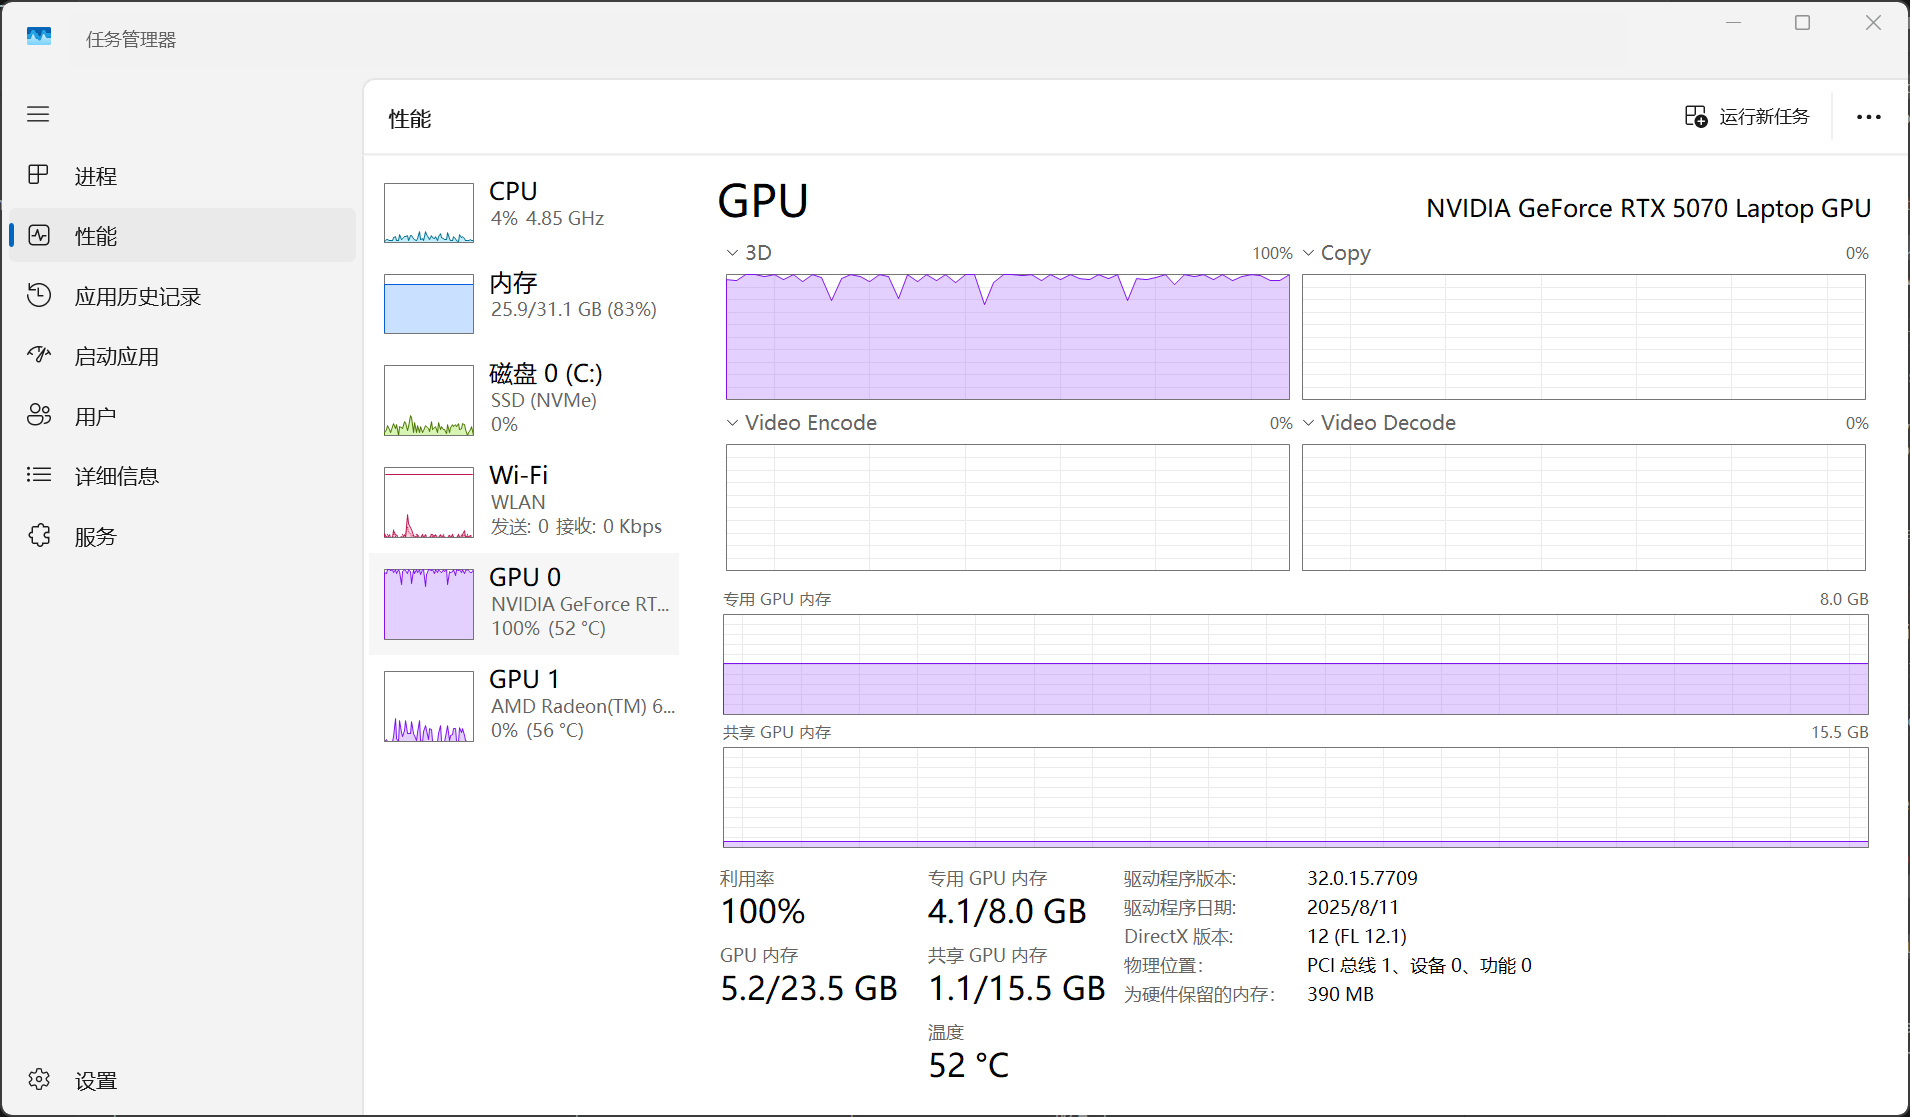